# Aprendizado não-supervisionado: outlier detection

In [0]:
# imports básicos
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from scipy.optimize import linprog

# machine learning
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Impacto dos outliers nos modelos

In [0]:
# gerando os dados
np.random.seed(1)
n = 40 #numero de amostras
x = np.linspace(0, 2, n).reshape(-1, 1)
fx = .5*x + 3 #função original do dado: ax + b
ruido = np.random.normal(scale=0.1, size=(n, 1)) # inserção de um ruído para teste
y = fx + ruido # dado que o algoritmo irá enxergar

In [0]:
# fit modelo linear
linear_regressor = LinearRegression()
linear_regressor.fit(x, y)
y_pred = linear_regressor.predict(x)
mse1 = mean_squared_error(y, y_pred)

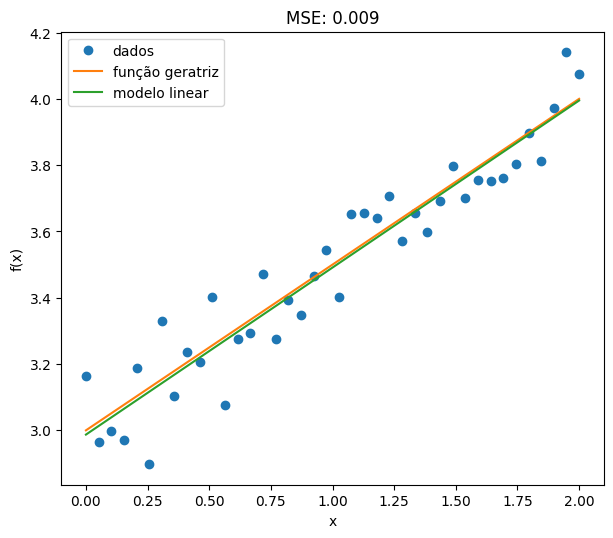

In [4]:
# plot da predição ( dado sem aparente outlier - mse próximo de zero)
plt.figure(figsize=(7, 6), dpi=100)
plt.plot(x, y, 'o', label='dados') # dados x e y
plt.plot(x, fx, label='função geratriz') # função origianl a que eu quero chegar mais perto dela. Beta = 
plt.plot(x, y_pred, label='modelo linear') # função predita
plt.title("MSE: {:.3f}".format(mse1)) # mediana com 3 casas decimais
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

In [0]:
# adição de outlier
y_outlier = y.copy() # vetor cópia do meu y
y_outlier[2:5] += 0.7 # incluir outlier entre as posições de 2 a 4, adicionando 0,7 em cada um

# fit modelo linear
linear_regressor = LinearRegression()
linear_regressor.fit(x, y_outlier) # rodas com o y com outlier
y_pred = linear_regressor.predict(x)
mse2 = mean_squared_error(y, y_pred) # como tem erro no y_outlier, não será usado aqui para calcularmos somente o erro em relação ao nosso dado original

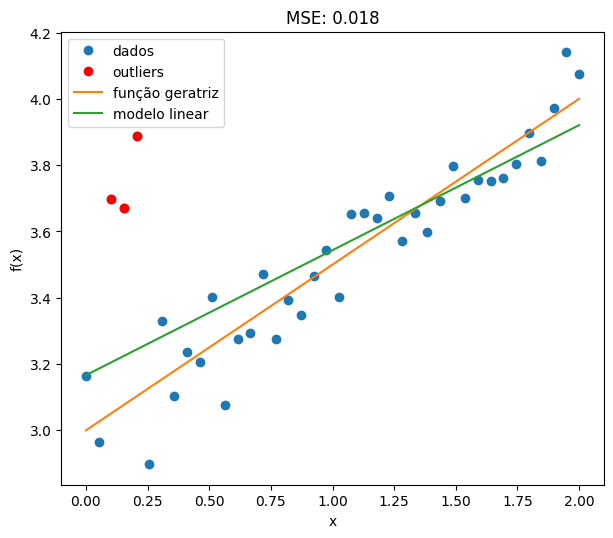

In [6]:
# plot da predição
plt.figure(figsize=(7, 6), dpi=100)
plt.plot(x, y_outlier, 'o', label='dados')
plt.plot(x[2:5], y_outlier[2:5], 'ro', label='outliers') # plot dos outliers
plt.plot(x, fx, label='função geratriz')
plt.plot(x, y_pred, label='modelo linear')
plt.title("MSE: {:.3f}".format(mse2))
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

In [0]:
# deletando o outlier
y_clean = np.delete(y_outlier, range(2, 5)).reshape(-1, 1)
x_clean = np.delete(x, range(2, 5)).reshape(-1, 1)

# fit modelo linear
linear_regressor = LinearRegression()
linear_regressor.fit(x_clean, y_clean)
y_pred = linear_regressor.predict(x_clean)
mse3 = mean_squared_error(y_clean, y_pred)

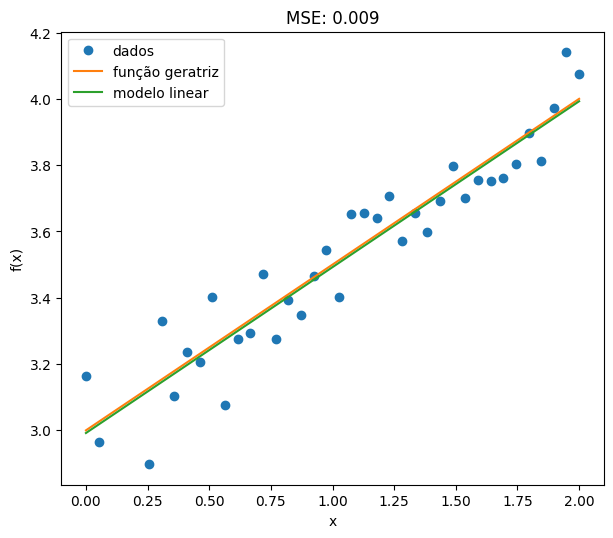

In [8]:
# plot da predição com a remoção dos outliers
plt.figure(figsize=(7, 6), dpi=100)
plt.plot(x_clean, y_clean, 'o', label='dados')
plt.plot(x, fx, label='função geratriz')
plt.plot(x_clean, y_pred, label='modelo linear')
plt.title("MSE: {:.3f}".format(mse3))
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

## Alteração para uma função de erro robusta

Sabendo que a regressão linear é um problema do tipo:

$$X\beta = y,$$

onde $\beta$ são os parâmetros a serem estimados através da minimização de uma função de erro (custo):

$$\min_\beta ||y-X\beta||_p.$$

Para $p=2$ (função de erro utilizada até o momento e mais comumente utilizada), temos a minimização do erro quadrático, que penaliza fortemente (ordem quadrática) erros altos, sendo, portanto, muito sensível aos outliers.

Em contrapartida, $p=1$ é uma função muito mais robusta aos outliers e é uma alternativa ao método tradicional. O ponto negativo dessa função de erro é que ela é mais complexa numericamente de ser otimizada e não existe solução analítica ([mais informações](https://github.com/matheusomendonca/optimization_experiments/blob/master/ipynb/Lp_Norm_Analysis.ipynb)).

A seguir, iremos escrever uma função de erro personalizada que minimiza a norma $p=1$ do nosso problema.

In [0]:
# regressão norma-1

class NormOneRegression:

  def __init__(self, fit_intercept=True):

    # inicializando
    self.fit_intercept = fit_intercept
    self.beta = None

  def fit(self, x, y):

    # verificando necessidade de adição de bias
    if self.fit_intercept:
      X = np.c_[np.ones(x.shape), x]
    else:
      X = x.copy()

    # cardinalidades
    n, m = X.shape

    # restrições de desigualdade
    A_ub1 = np.c_[X, -np.eye(n)]
    A_ub2 = np.c_[-X, -np.eye(n)]
    A_ub = np.r_[A_ub1, A_ub2]

    # limites da restrição de desigualdade
    b_ub = np.r_[y, -y]

    # coeficientes do problema
    c = np.ones((A_ub.shape[1], 1))
    c[0:m] = 0

    # limites
    x_bounds = np.c_[-np.inf*np.ones((m+n, 1)), np.inf*np.ones((m+n, 1))]
    x_bounds[m:, 0] = 0

    # otimização 
    output = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=x_bounds,
                     options={'cholesky':False,
                              'sym_pos':False,
                              'lstsq':True,
                              'presolve':True})

    # resultado
    self.beta = output.x[:m].reshape(-1, 1)

  def predict(self, X):

    # verificando necessidade de adição de bias
    if self.fit_intercept:
      X = np.c_[np.ones(x.shape), x]
    else:
      X = x.copy()

    # resultado
    return np.dot(X, self.beta)

In [0]:
# modelo otimizando a norma 1
model = NormOneRegression()
model.fit(x, y_outlier)
y_pred = model.predict(x)
mse4 = mean_squared_error(y, y_pred)

In [13]:
model.beta 

array([[3.055381 ],
       [0.4427746]])

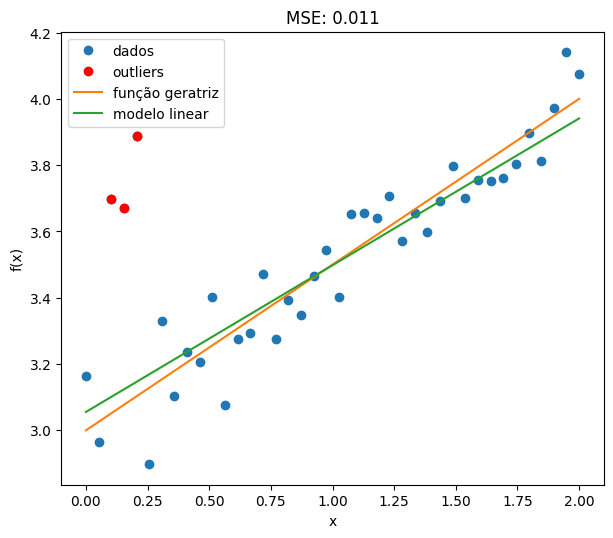

In [11]:
# plot da predição
plt.figure(figsize=(7, 6), dpi=100)
plt.plot(x, y_outlier, 'o', label='dados')
plt.plot(x[2:5], y_outlier[2:5], 'ro', label='outliers')
plt.plot(x, fx, label='função geratriz')
plt.plot(x, y_pred, label='modelo linear')
plt.title("MSE: {:.3f}".format(mse4))
plt.legend()
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

In [12]:
# percentual da diferente entre o mse do modelo com o outlier, 0,018 e com esse algorimo robusto
print("Melhoria percentual do MSE utilizando" + 
      " a nova função de custo {:.2f} (%)".format((mse2-mse4)/mse2*100))

Melhoria percentual do MSE utilizando a nova função de custo 39.73 (%)


## Outlier detection: Isolation Forest

In [0]:
# parâmetros dos dados
n_samples = 200
outliers_fraction = 0.25 # 25% dos dados tem outlier
x_min, x_max = -7, 7 # definir o range de qutando a quanto os dados irão variar

# real
n_inliers = int((1. - outliers_fraction) * n_samples) # dados inlier
n_outliers = int(outliers_fraction * n_samples) # dados outlier
ground_truth = np.ones(n_samples, dtype=int) # o que de fato eu quero - tudo o que é outlier é -1
ground_truth[-n_outliers:] = -1

In [15]:
print (ground_truth)

[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1]


In [0]:
# gerando os dados aleatórios
np.random.seed(1)

# amostras inliers
offset = 0 
X1 = 0.3 * np.random.randn(n_inliers // 2, 2) + offset
X2 = 0.3 * np.random.randn(n_inliers // 2, 2) - offset
X = np.r_[X1, X2] # concatenar as duas matrizes

# amostras outliers
X = np.r_[X, np.random.uniform(low=x_min+1,
                               high=x_max-1, size=(n_outliers, 2))]

In [17]:
# print dos parâmetros
print('Número de liers: %i' % n_inliers)
print('Número de outliers: %i' % n_outliers)
print(f'Ground truth, tamanho {ground_truth.shape[0]}:'+
 ' Outlier (-1) e inliers (1).\n')
print(ground_truth)

Número de liers: 150
Número de outliers: 50
Ground truth, tamanho 200: Outlier (-1) e inliers (1).

[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1]


No handles with labels found to put in legend.


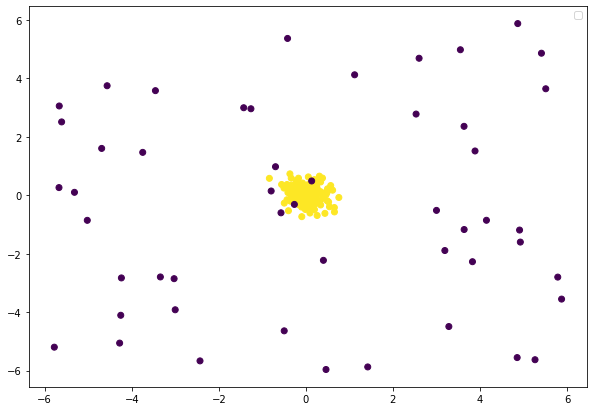

In [0]:
# visualização inicial dos dados
plt.figure(figsize=(10, 7))
plt.scatter(X[:, 0], X[:, 1], c=ground_truth) # duas dimensões 1a x[:,0] e o 2o x[:,1]
plt.legend()
plt.show()

In [0]:
# outliear detector model
outlier_detector = IsolationForest()

In [0]:
def plot_decision_function(model, X): # x matriz com os dados
  """ Plot da superfície de decisão do modelo.

    Args:
      model: instancia do modelo.
      X: matriz com os dados.
  """
 
  # fit do modelo e determinação de outliers
  outlier_detector.fit(X)
  scores_pred = outlier_detector.decision_function(X) # resultado entre 1 e -1
  y_pred = outlier_detector.predict(X) # resultado ou é 0 ou é 1
  threshold = np.percentile(scores_pred[::-1], 100 * outliers_fraction)
  n_errors = (y_pred != ground_truth).sum() 

  # meshgrid
  n_points_grid = 100
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, n_points_grid),
                       np.linspace(x_min, x_max, n_points_grid))
  Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()]) 
  Z = Z.reshape(xx.shape)

  # plot das curvas de nível e dos pontos
  plt.figure(figsize=(7, 6), dpi=100)
  subplot = plt.subplot(1, 1, 1)
  subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                    cmap=plt.cm.Blues_r)
  a = subplot.contour(xx, yy, Z, levels=[threshold],
                      linewidths=2, colors='red')
  subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                    colors='orange')
  b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white',
                      s=20, edgecolor='k')
  c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black',
                      s=20, edgecolor='k')
  subplot.axis('tight')
  subplot.legend(
      [a.collections[0], b, c],
      ['superfíce de decisão aprendida',
       'verdadeiros inliers',
       'verdadeiros outliers'],
      prop=matplotlib.font_manager.FontProperties(size=10),
      loc='lower right')
  subplot.set_xlim((-7, 7))
  subplot.set_ylim((-7, 7))
  plt.title('Outlier detection,' +
            f' # de erros: {n_errors} ({n_errors/n_samples*100}%)')
  plt.show() 

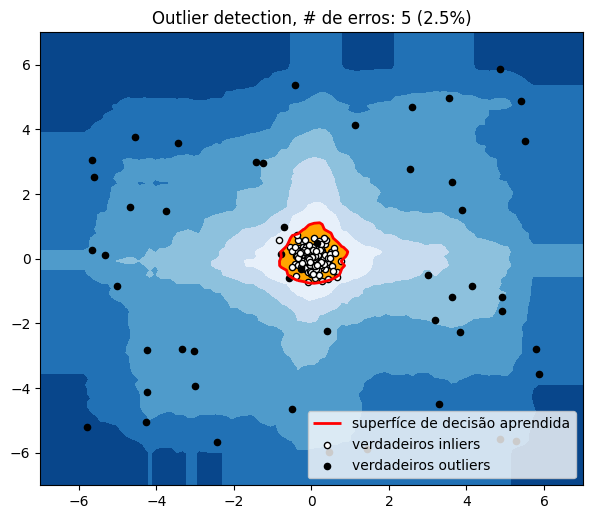

In [21]:
# visualização dos resultados
plot_decision_function(model=outlier_detector, X=X) # grafico bidimensional

tudo o que está dentro da linha vermelha e for branco, o algoritmo acerto e o que for preto, o algoritmo errou. O que foi branco fora da linha vermelha, quer dizer que o algoritmo errou.

Os valores retornados pelo método `decision_function` (valor entre -1 e 1) podem ser interpretados como um nível de anomalia: quanto mais próximo de -1 mais anômalo é a amostra.